<a href="https://colab.research.google.com/github/ruthetum/Deeplearning-NLP/blob/master/naverMovie.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 네이버 영화 리뷰 데이터 분석

# 1. 데이터 정보

In [1]:
!pip install konlpy
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

     |████████████████████████████████| 19.4MB 159kB/s 
     |████████████████████████████████| 92kB 13.8MB/s 
     |████████████████████████████████| 2.4MB 53.7MB/s 
  Found existing installation: tweepy 3.6.0
    Uninstalling tweepy-3.6.0:
      Successfully uninstalled tweepy-3.6.0
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


# 1) 데이터 로드

In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x7f47cd0f55f8>)

In [0]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

In [4]:
print('훈련용 리뷰 개수 :',len(train_data))

훈련용 리뷰 개수 : 150000


In [5]:
train_data[:5] # 상위 5개 출력

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [6]:
print('테스트용 리뷰 개수 :',len(test_data))

테스트용 리뷰 개수 : 50000


# 2) 데이터 정제

In [7]:
# 중복 확인
train_data['document'].nunique(), train_data['label'].nunique()

(146182, 2)

In [0]:
# 중복 제거 (150000 -> 146182)
train_data.drop_duplicates(subset=['document'], inplace=True)

In [9]:
print('총 샘플의 수 :',len(train_data))

총 샘플의 수 : 146183


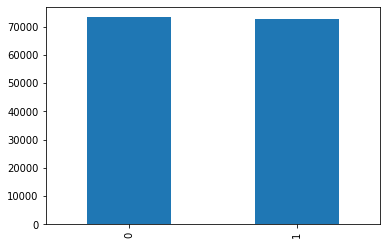

In [10]:
train_data['label'].value_counts().plot(kind = 'bar')

In [11]:
print(train_data.groupby('label').size().reset_index(name = 'count'))

   label  count
0      0  73342
1      1  72841


In [12]:
# NULL 값 확인
print(train_data.isnull().values.any())

True


In [13]:
# document에 NULL 값 존재
print(train_data.isnull().sum())

id          0
document    1
label       0
dtype: int64


In [14]:
train_data.loc[train_data.document.isnull()]

,id,document,label
25857,2172111,NaN,1


In [15]:
# Null 값이 존재하는 행 제거
train_data = train_data.dropna(how = 'any')

# Null 값이 존재하는지 확인
print(train_data.isnull().values.any()) 

False


In [16]:
print(len(train_data))

146182


# +++ 영어 전처리 +++

[a-zA-Z]랑 '' 하면 알파벳, 공백 제외하고 모두 제거

In [17]:
text = 'do!!! you expect... people~ to~ read~ the FAQ, etc. and actually accept hard~! atheism?@@'
re.sub(r'[^a-zA-Z ]', '', text)

'do you expect people to read the FAQ etc and actually accept hard atheism'

# +++ 한글 전처리 +++

* ㄱ ~ ㅎ: 3131 ~ 314E
* ㅏ ~ ㅣ: 314F ~ 3163

**완성형 한글의 범위는 가 ~ 힣**

In [18]:
# 한글, 공백 제외하고 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data[:5]

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


In [19]:
# 한글, 공백 제외하고 제거했을 경우 알파벳이랑 특수문자로 된 document는 NULL 값이 되버림
train_data['document'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

id            0
document    391
label         0
dtype: int64


In [20]:
# NULL 값된 행 제거
train_data = train_data.dropna(how = 'any')
print(len(train_data))

145791


In [21]:
# 테스트에서도 똑같이
test_data.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 48995


# 참고

여기서는
1. NULL 값 제거
2. document 중복값 행 제거
3. 정규표현식으로 한글, 공백 제외하고 제거
4. 공백 NULL 값으로 변경
5. NULL 값 제거

이런 식으로 전처리를 진행했는데

정규표현식으로 한글, 공백 제외하고 제거 하면서

또 중복값인 document가 발생할 수 있으므로

1 - 2 - 3 - 4 - 5 - 2 로 중복을 또 제거해야 되는 걸 생각하면

1 - 3 - 4 - 5 - 2 가 좋을 수도 있는데

어떻게 보면 미리 중복값을 제거해서 데이터의 수를 줄인 상태에서 정규표현식으로 걸러주면

그만큼 데이터의 수가 줄어든 상태에서 연산 과정이 있다보니 속도면에서는 이득을 볼 수도 있을 듯,.

# 3) 토큰화

In [0]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

# stem = True를 설정할 경우

일정 수준의 정규화를 수행해주는데, 예제의 결과를 보면

'이런'이 '이렇다'로 변환되었고 '만드는'이 '만들다'로 변환

In [23]:
okt = Okt()
okt.morphs('와 이런 것도 영화라고 차라리 뮤직비디오를 만드는 게 나을 뻔', stem = True)

['오다', '이렇다', '것', '도', '영화', '라고', '차라리', '뮤직비디오', '를', '만들다', '게', '나다', '뻔']

In [24]:
from konlpy.tag import Kkma

kkma = Kkma()
kkma.morphs('와 이런 것도 영화라고 차라리 뮤직비디오를 만드는 게 나을 뻔')

['오',
 '아',
 '이렇',
 'ㄴ',
 '것',
 '도',
 '영화',
 '라고',
 '차라리',
 '뮤직',
 '비디오',
 '를',
 '만들',
 '는',
 '것',
 '이',
 '낫',
 '을',
 '뻔']

In [25]:
# train 데이터 토큰화 및 불용어 제거
X_train = []
for sentence in train_data['document']:
    temp_X = []
    # 토큰화
    temp_X = okt.morphs(sentence, stem=True)
    # 불용어 제거
    temp_X = [word for word in temp_X if not word in stopwords]
    X_train.append(temp_X)

KeyboardInterrupt: ignored

In [26]:
print(X_train[:3])

[['아', '더빙', '진짜', '짜증나다', '목소리'], ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍다', '않다'], ['너', '무재', '밓었', '다그', '래서', '보다', '추천', '다']]


In [27]:
# test 데이터 토큰화 및 불용어 제거
X_test = []
for sentence in test_data['document']:
    temp_X = []
    temp_X = okt.morphs(sentence, stem=True)
    temp_X = [word for word in temp_X if not word in stopwords]
    X_test.append(temp_X)

KeyboardInterrupt: ignored

# 4) 정수 인코딩

In [0]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [0]:
print(tokenizer.word_index)

In [0]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍을 key와 value로 받음
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

In [0]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거. 0번 패딩 토큰을 고려하여 +1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

In [0]:
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [0]:
print(X_train[:3])

In [0]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

# 5) 빈(empty) 샘플 제거

빈도 수가 낮은 단어를 삭제했다는 것은

빈도 수가 낮은 단어들로 구성된 샘플은 빈 샘플이 되었다는 것

따라서 빈 샘플 제거

In [0]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]
drop_test = [index for index, sentence in enumerate(X_test) if len(sentence) < 1]

In [0]:
# 빈 샘플 제거
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

In [0]:
# test 데이터에서도
X_test = np.delete(X_test, drop_test, axis=0)
y_test = np.delete(y_test, drop_test, axis=0)
print(len(X_test))
print(len(y_test))

# 6) 패딩

샘플 별로 길이가 다르므로 일정하게

In [0]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [0]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [0]:
# 위의 분포를 봤을 때 max_len이 30 정도면 대부분의 샘플을 커버 가능 / 30 이하의 샘플 94%
max_len = 30
below_threshold_len(max_len, X_train)

In [0]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

# 2. LSTM으로 네이버 영화 리뷰 감성 분류

In [0]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [0]:
model = Sequential()
model.add(Embedding(vocab_size, 100)) # 임베딩 벡터 차원 100
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

In [0]:
# 검증 데이터 손실(val_loss)이 증가하면, 과적합 징후므로 검증 데이터 손실이 4회 증가하면 학습을 조기 종료(Early Stopping)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [0]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=60, validation_split=0.2) # validation 20%

In [0]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))